In [6]:
import numpy as np
import pandas as pd
import xarray as xr
from rasterio.enums import Resampling

from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [7]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

def bias(x, y): return np.mean(x - y)

def get_stats(x, y):
    warnings.filterwarnings("ignore", message="An input array is constant")
    if type(x) == xr.DataArray: x = x.values.ravel()
    if type(y) == xr.DataArray: y = y.values.ravel()
    if type(x) == list: x = np.array(x)
    if type(y) == list: y = np.array(y)
    idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[idx], y[idx]
    r, p = pearsonr(x, y)
    b = bias(x, y)
    mae = mean_absolute_error(x, y)
    rmse = mean_squared_error(x, y, squared = False)
    return r, b, mae, rmse

In [16]:
in_dir = Path('~/scratch/spicy/SnowEx-Hans-s1').expanduser()
han_dss = {fp.stem: xr.open_dataset(fp).rio.write_crs('EPSG:4326') for fp in in_dir.glob('*.nc')}


in_dir = Path('~/spicy-snow/SnowEx-Data/').expanduser().resolve()

our_dss = {fp.stem: xr.open_dataset(fp).rio.write_crs('EPSG:4326') for fp in in_dir.glob('*.nc')}

In [31]:
res= pd.DataFrame()
for k in our_dss.keys():
    our = our_dss[k]['snow_depth'].interpolate_na('x').sortby('y').interpolate_na('y').transpose('time', 'y', 'x').rio.reproject_match(han_dss[k]['snd'], resampling = Resampling.bilinear, nodata =np.nan).dropna('time', how ='all')
    hn = han_dss[k]['snd']
    if len(hn.time) == 0: continue
    rs = []
    for ts in our.time:
        # try:
        #     hn.sel(time = ts)
        # except KeyError:
        #     continue
        # fig,axes=plt.subplots(1, 2)
        # our.sel(time = ts, method = 'nearest').plot(ax = axes[0])
        # hn.sel(time = ts, method = 'nearest').plot(ax = axes[1])
        # plt.show()
        try:
            r, _,_,rmse = get_stats(our.sel(time = ts), hn.sel(time = ts, method = 'nearest', tolerance = '1 days'))
            rs.append(r)
        except KeyError:
            continue
    res.loc[k, 'spicy-hans-r']= np.nanmean(rs)

    res.loc[k, 'hans-lidar-r'] = get_stats(our_dss[k]['lidar-sd'].transpose('y', 'x').rio.reproject_match(hn, resampling = Resampling.average), hn.sel(time = k.split("_")[-1],method ='nearest'))[0]
    res.loc[k, 'spicy-lidar-r'] = get_stats(our_dss[k]['lidar-sd'].transpose('y', 'x').rio.reproject_match(hn, resampling = Resampling.average), our.sel(time = k.split("_")[-1],method ='nearest'))[0]

    res.loc[k, 'hans-lidar-rmse'] = get_stats(our_dss[k]['lidar-sd'].transpose('y', 'x').rio.reproject_match(hn, resampling = Resampling.average), hn.sel(time = k.split("_")[-1],method ='nearest'))[3]
    res.loc[k, 'spicy-lidar-rmse'] = get_stats(our_dss[k]['lidar-sd'].transpose('y', 'x').rio.reproject_match(hn, resampling = Resampling.average), our.sel(time = k.split("_")[-1],method ='nearest'))[3]
print(f"Correlation hans to spicy is {res['spicy-hans-r'].mean()}")
print(f"We are doing : {(res['spicy-lidar-r'] - res['hans-lidar-r']).mean()} better in correlation")
print(f"We are doing : {(res['spicy-lidar-rmse'] - res['hans-lidar-rmse']).mean()} better in rmse")

Correlation hans to spicy is 0.6387271922654845
We are doing : 0.0033627940394623107 better in correlation
We are doing : 0.09370169086922481 better in rmse


In [28]:
res

,spicy-hans-r,hans-lidar-r,spicy-lidar-r,hans-lidar-rmse,spicy-lidar-rmse
Mores_2020-02-09,0.652895,0.605069,0.243348,0.834707,0.840533
Frasier_2021-03-19,0.615252,-0.097972,0.240129,0.759483,0.545611
Dry_Creek_2020-02-19,0.487339,0.518550,0.337778,0.413437,0.570771
Banner_2021-03-15,0.569840,0.408965,0.564072,0.555527,0.495296
Little_Cottonwood_2021-03-18,0.812777,0.672250,0.699285,0.683653,0.647446
Mores_2021-03-15,0.637208,0.620214,0.594030,0.420841,0.633128
Banner_2020-02-18,0.739969,0.641006,0.633625,0.910552,0.772023
Frasier_2020-02-11,0.643462,0.410448,0.475807,0.355757,0.809566
Cameron_2021-03-19,0.589802,-0.075677,-0.054956,0.429195,0.892093


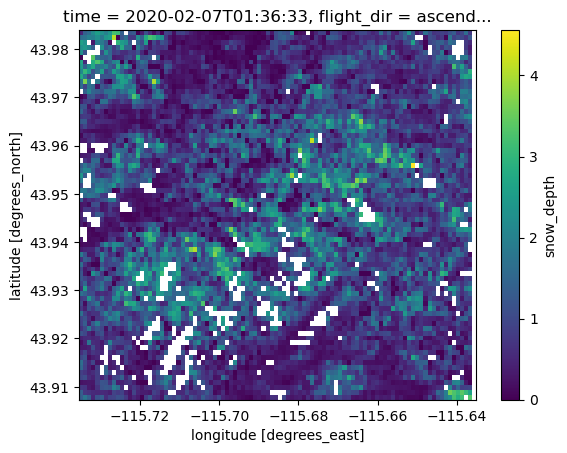

In [22]:
our_dss['Mores_2020-02-09'].sel(time = '2020-02-09', method = 'nearest', tolerance = '3 days')['snow_depth'].plot()

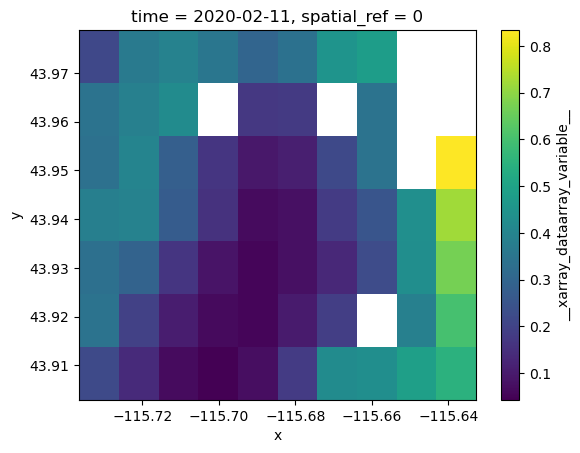

In [25]:
han_dss['Mores_2020-02-09'].sel(time = '2020-02-09', method = 'nearest', tolerance = '3 days')['__xarray_dataarray_variable__'].T.plot()

In [14]:
res

,spicy-hans-r,hans-lidar-r,spicy-lidar-r
Mores_2020-02-09,-0.070579,0.012317,0.415872
Dry_Creek_2020-02-19,-0.055541,0.227491,0.303458
Banner_2021-03-15,NaN,-0.057282,0.624687
Little_Cottonwood_2021-03-18,NaN,0.426057,0.898450
Mores_2021-03-15,NaN,NaN,0.722559
Banner_2020-02-18,-0.038905,-0.038096,0.715739


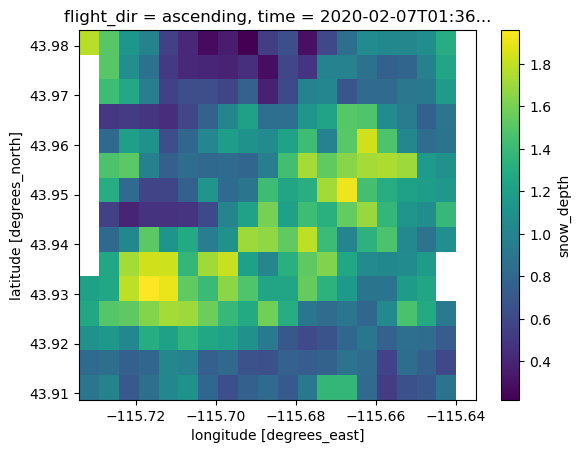

In [75]:
b=our_dss['Mores_2020-02-09'].interpolate_na('x').transpose('time', 'y', 'x').rio.reproject_match(han_dss['Mores_2020-02-09']['snd'], resampling = Resampling.bilinear).dropna('time', how ='all')['snow_depth'].sel(time= '2020-02-09', method ='nearest')
b.plot()

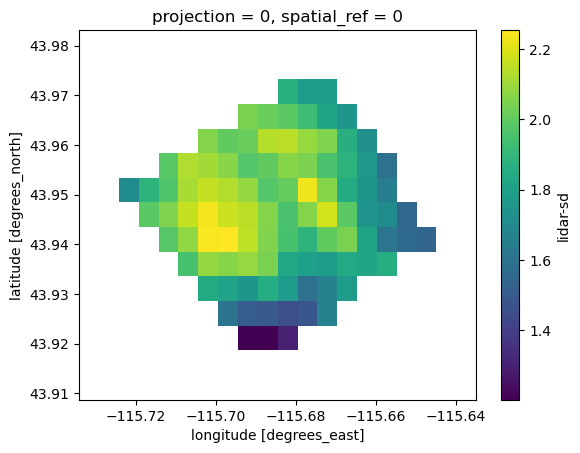

In [76]:
a = our_dss['Mores_2020-02-09']['lidar-sd'].interpolate_na('x').sortby('y').interpolate_na('y').transpose('y', 'x')
a = a.rio.reproject_match(han_dss['Mores_2020-02-09']['snd'], resampling = Resampling.bilinear)
a.plot()

In [78]:
get_stats(a, b)[0]

-0.10928613914771293

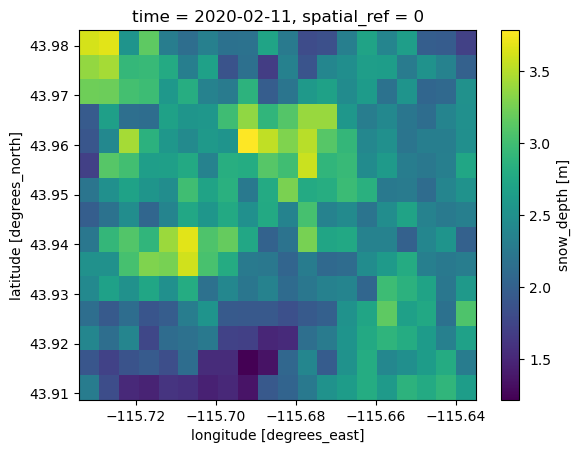

In [69]:
c = han_dss['Mores_2020-02-09'].sel(time='2020-02-09', method = 'nearest')['snd']
c.plot()

In [48]:
res.sort_values('spicy-hans-r', ascending = False)

,spicy-hans-r,hans-lidar-r,spicy-lidar-r
Little_Cottonwood_2021-03-18,0.816026,0.672250,0.695781
Banner_2020-02-18,0.746636,0.641006,0.618279
Mores_2021-03-15,0.741802,0.620214,0.618917
Mores_2020-02-09,0.661639,0.605069,0.055511
Banner_2021-03-15,0.648090,0.408965,0.497107
Frasier_2020-02-11,0.636835,0.410448,0.483736
Frasier_2021-03-19,0.623917,-0.097972,0.163410
Cameron_2021-03-19,0.619956,-0.075677,-0.105129
Dry_Creek_2020-02-19,0.598675,0.518550,0.331877
